In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv")
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


## Exploratory Data Analysis
Look at the fuel_efficiency_mpg variable. Does it have a long tail?

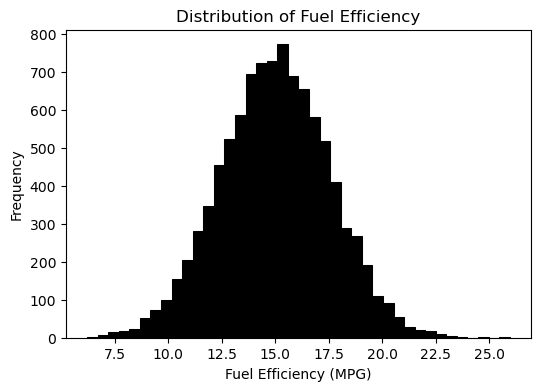

In [3]:
plt.figure(figsize=(6, 4))

sns.histplot(df.fuel_efficiency_mpg, bins=40, color='black', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Fuel Efficiency (MPG)')
plt.title('Distribution of Fuel Efficiency')

plt.show()

In [4]:
print("Statistical Summary of fuel_efficiency_mpg:")
print(df['fuel_efficiency_mpg'].describe())
print(f"\nSkewness: {df['fuel_efficiency_mpg'].skew():.3f}")
print(f"Kurtosis: {df['fuel_efficiency_mpg'].kurtosis():.3f}")

Q1 = df['fuel_efficiency_mpg'].quantile(0.25)
Q3 = df['fuel_efficiency_mpg'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['fuel_efficiency_mpg'] < lower_bound) | (df['fuel_efficiency_mpg'] > upper_bound)]
print(f"\nOutliers (beyond 1.5*IQR): {len(outliers)} values")
print(f"Percentage of outliers: {len(outliers)/len(df)*100:.2f}%")

print(f"\nRange: {df['fuel_efficiency_mpg'].min():.3f} to {df['fuel_efficiency_mpg'].max():.3f}")
print(f"95th percentile: {df['fuel_efficiency_mpg'].quantile(0.95):.3f}")
print(f"99th percentile: {df['fuel_efficiency_mpg'].quantile(0.99):.3f}")

Statistical Summary of fuel_efficiency_mpg:
count    9704.000000
mean       14.985243
std         2.556468
min         6.200971
25%        13.267459
50%        15.006037
75%        16.707965
max        25.967222
Name: fuel_efficiency_mpg, dtype: float64

Skewness: -0.012
Kurtosis: 0.023

Outliers (beyond 1.5*IQR): 83 values
Percentage of outliers: 0.86%

Range: 6.201 to 25.967
95th percentile: 19.150
99th percentile: 20.882


In [5]:
df.isna().sum()

engine_displacement      0
num_cylinders          482
horsepower             708
vehicle_weight           0
acceleration           930
model_year               0
origin                   0
fuel_type                0
drivetrain               0
num_doors              502
fuel_efficiency_mpg      0
dtype: int64

## Question 2
What's the median (50% percentile) for variable 'horsepower'?

In [6]:
df["horsepower"].median()

149.0

## Question 3
- We need to deal with missing values for the column from Q1.
- We have two options: fill it with 0 or with the mean of this variable.
- Try both options. For each, train a linear regression model without - regularization using the code from the lessons.
- For computing the mean, use the training only!
- Use the validation dataset to evaluate the models and compare the RMSE of each option.
- Round the RMSE scores to 2 decimal digits using round(score, 2)
- Which option gives better RMSE?

Options:

- With 0
- With mean
- Both are equally good


In [7]:

# Set random seed for reproducibility
np.random.seed(42)

# Shuffle the dataset
n = len(df)
idx = np.arange(n)
np.random.shuffle(idx)
df_shuffled = df.iloc[idx].reset_index(drop=True)

# Split into train, validation, test
n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = int(0.6 * n)


df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

# Define target variable (fuel efficiency)
y_train = df_train['fuel_efficiency_mpg'].values
y_val = df_val['fuel_efficiency_mpg'].values
y_test = df_test['fuel_efficiency_mpg'].values

In [8]:
# Prepare feature matrices (use only specified columns)
numerical_cols = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']

# Create feature matrices
X_train = df_train[numerical_cols].copy()
X_val = df_val[numerical_cols].copy() 
X_test = df_test[numerical_cols].copy()

In [9]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg
    
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [10]:
# Option 1: Fill with 0
X_train_fill_0 = X_train.fillna(0)
X_val_fill_0 = X_val.fillna(0)

# Option 2: Fill with mean
fill_values = X_train.mean()
X_train_fill_mean = X_train.fillna(fill_values)
X_val_fill_mean = X_val.fillna(fill_values)

# Train models and evaluate
def evaluate_model(X_train, X_val, y_train, y_val, name):
    w_0, w = train_linear_regression(X_train, y_train)
    
    y_pred = w_0 + X_val.dot(w)
    score = rmse(y_val, y_pred)
    
    print(f"{name}: RMSE = {round(score, 2)}")
    return round(score, 2)

score_fill_0 = evaluate_model(X_train_fill_0, X_val_fill_0, y_train, y_val, "Fill with 0")
score_fill_mean = evaluate_model(X_train_fill_mean, X_val_fill_mean, y_train, y_val, "Fill with mean")

if score_fill_0 < score_fill_mean:
    print("Better option: Fill with 0")
elif score_fill_mean < score_fill_0:
    print("Better option: Fill with mean")  
else:
    print("Both options are equally good")

Fill with 0: RMSE = 0.52
Fill with mean: RMSE = 0.46
Better option: Fill with mean


## Question 4
- Now let's train a regularized linear regression.
- For this question, fill the NAs with 0.
- Try different values of r from this list: [0, 0.01, 0.1, 1, 5, 10, - 100].
- Use RMSE to evaluate the model on the validation dataset.
- Round the RMSE scores to 2 decimal digits.
- Which r gives the best RMSE?

If multiple options give the same best RMSE, select the smallest r.

Options:

- 0
- 0.01
- 1
- 10
- 100


In [11]:
# Fill NAs with 0
X_train_q4 = X_train.fillna(0)
X_val_q4 = X_val.fillna(0)

# Test different regularization values
r_values = [0, 0.01, 0.1, 1, 5, 10, 100]
results_q4 = []

for r in r_values:
    w_0, w = train_linear_regression_reg(X_train_q4, y_train, r=r)
    
    # Make predictions
    y_pred = w_0 + X_val_q4.dot(w)
    score = rmse(y_val, y_pred)
    score_rounded = round(score, 2)
    results_q4.append((r, score_rounded))
    
    print(f"r = {r}: RMSE = {score_rounded}")

best_score = min(results_q4, key=lambda x: x[1])[1]
best_r_values = [r for r, score in results_q4 if score == best_score]
best_r = min(best_r_values)

print(f"\nBest r: {best_r} (RMSE = {best_score})")

r = 0: RMSE = 0.52
r = 0.01: RMSE = 0.52
r = 0.1: RMSE = 0.52
r = 1: RMSE = 0.52
r = 5: RMSE = 0.52
r = 10: RMSE = 0.52
r = 100: RMSE = 0.52

Best r: 0 (RMSE = 0.52)


## Question 5
- We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
- Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
- For each seed, do the train/validation/test split with 60%/20%/20% distribution.
- Fill the missing values with 0 and train a model without regularization.
- For each seed, evaluate the model on the validation dataset and - collect the RMSE scores.
- What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
- Round the result to 3 decimal digits (round(std, 3))

What's the value of std?

- 0.001
- 0.006
- 0.060
- 0.600

In [12]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
seed_scores = []

for seed in seeds:
    # Set seed and shuffle
    np.random.seed(seed)
    n = len(df)
    idx = np.arange(n)
    np.random.shuffle(idx)
    df_shuffled_seed = df.iloc[idx].reset_index(drop=True)
    
    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = int(0.6 * n)
    
    df_train_seed = df_shuffled_seed.iloc[:n_train].copy()
    df_val_seed = df_shuffled_seed.iloc[n_train:n_train+n_val].copy()
    
  
    X_train_seed = df_train_seed[numerical_cols].fillna(0)
    X_val_seed = df_val_seed[numerical_cols].fillna(0)
    y_train_seed = df_train_seed['fuel_efficiency_mpg'].values
    y_val_seed = df_val_seed['fuel_efficiency_mpg'].values
    
    w_0, w = train_linear_regression(X_train_seed, y_train_seed)
    y_pred = w_0 + X_val_seed.dot(w)
    score = rmse(y_val_seed, y_pred)
    
    seed_scores.append(score)
    print(f"Seed {seed}: RMSE = {round(score, 2)}")

std_scores = np.std(seed_scores)
print(f"\nStandard deviation: {round(std_scores, 3)}")
print(f"All scores: {[round(s, 3) for s in seed_scores]}")

Seed 0: RMSE = 0.52
Seed 1: RMSE = 0.52
Seed 2: RMSE = 0.52
Seed 3: RMSE = 0.52
Seed 4: RMSE = 0.51
Seed 5: RMSE = 0.53
Seed 6: RMSE = 0.53
Seed 7: RMSE = 0.51
Seed 8: RMSE = 0.51
Seed 9: RMSE = 0.51

Standard deviation: 0.007
All scores: [np.float64(0.521), np.float64(0.522), np.float64(0.523), np.float64(0.516), np.float64(0.511), np.float64(0.529), np.float64(0.532), np.float64(0.51), np.float64(0.515), np.float64(0.513)]


## Question 6
- Split the dataset like previously, use seed 9.
- Combine train and validation datasets.
- Fill the missing values with 0 and train a model with r=0.001.
- What's the RMSE on the test dataset?

Options:

- 0.15
- 0.515
- 5.15
- 51.5

In [13]:

np.random.seed(9)

# Shuffle the dataset with seed 9
n = len(df)
idx = np.arange(n)
np.random.shuffle(idx)
df_shuffled_final = df.iloc[idx].reset_index(drop=True)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

df_train_final = df_shuffled_final.iloc[:n_train].copy()
df_val_final = df_shuffled_final.iloc[n_train:n_train+n_val].copy()
df_test_final = df_shuffled_final.iloc[n_train+n_val:].copy()

df_train_val_combined = pd.concat([df_train_final, df_val_final], ignore_index=True)

X_train_val_combined = df_train_val_combined[numerical_cols].fillna(0)
y_train_val_combined = df_train_val_combined['fuel_efficiency_mpg'].values


X_test_final = df_test_final[numerical_cols].fillna(0)
y_test_final = df_test_final['fuel_efficiency_mpg'].values


w_0, w = train_linear_regression_reg(X_train_val_combined, y_train_val_combined, r=0.001)

y_pred_test = w_0 + X_test_final.dot(w)
test_rmse = rmse(y_test_final, y_pred_test)

print(f"Test RMSE with r=0.001: {round(test_rmse, 3)}")
print(f"Combined train+val size: {len(X_train_val_combined)}")
print(f"Test size: {len(X_test_final)}")

Test RMSE with r=0.001: 0.516
Combined train+val size: 7764
Test size: 1940
